In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')

# Configuração de estilo para gráficos
sns.set_theme(style="whitegrid")


# Pré-visualização dos Dados

In [2]:
# Leitura do arquivo CSV
df = pd.read_csv("miro_dados_limpos_ultimos_30_dias.csv")

In [3]:
# Exibe informações gerais do dataset
print("\nInformações sobre o dataset:")
print(f"Número de linhas: {df.shape[0]}")
print(f"Número de colunas: {df.shape[1]}")


Informações sobre o dataset:
Número de linhas: 5
Número de colunas: 22


# Estatísticas Descritivas do `.describe()`

1.  **count**:

    - **Definição**: Conta o número de entradas válidas (não nulas) em cada coluna.
    - **Cálculo**: Número total de valores presentes em uma coluna, ignorando valores ausentes (`NaN`).
    - **Uso**: Útil para verificar a quantidade de dados disponíveis e se há muitas lacunas em uma coluna.

2.  **mean** (Média):

    - **Definição**: A média aritmética dos valores na coluna.
    - **Cálculo**: Soma de todos os valores dividida pelo número total de valores não nulos.
    - **Uso**: Indica o valor médio de uma coluna, ajudando a identificar o centro da distribuição dos dados.

3.  **std** (Desvio Padrão):

    - **Definição**: Mede a dispersão dos valores em relação à média.
    - **Cálculo**: Raiz quadrada da média dos quadrados das diferenças entre cada valor e a média.
    - **Uso**: Indica a variabilidade dos dados; quanto maior o desvio padrão, mais dispersos estão os dados em torno da média.

4.  **min** (Valor Mínimo):

    - **Definição**: O menor valor encontrado na coluna.
    - **Cálculo**: Simplesmente o valor mais baixo da série.
    - **Uso**: Mostra o limite inferior dos valores e ajuda a identificar possíveis outliers (valores muito baixos).

5.  **25%** (1º Quartil):

    - **Definição**: O valor abaixo do qual 25% dos dados estão situados.
    - **Cálculo**: Valor que divide os 25% menores valores dos restantes.
    - **Uso**: Indica o limite inferior do intervalo interquartil e ajuda a entender a dispersão dos dados na parte baixa.

6.  **50%** (Mediana ou 2º Quartil):

    - **Definição**: O valor central da distribuição.
    - **Cálculo**: O valor no meio dos dados quando organizados em ordem crescente.
    - **Uso**: É uma medida de tendência central mais robusta que a média, pois não é afetada por outliers.

7.  **75%** (3º Quartil):

    - **Definição**: O valor abaixo do qual 75% dos dados estão situados.
    - **Cálculo**: Valor que divide os 75% menores valores dos restantes.
    - **Uso**: Indica o limite superior do intervalo interquartil, ajudando a identificar a dispersão dos dados na parte alta.

8.  **max** (Valor Máximo):
    - **Definição**: O maior valor encontrado na coluna.
    - **Cálculo**: Simplesmente o valor mais alto da série.
    - **Uso**: Mostra o limite superior dos valores e ajuda a identificar possíveis outliers (valores muito altos).

Essas estatísticas fornecem uma visão abrangente da distribuição dos dados, destacando o centro (média e mediana), a dispersão (desvio padrão e quartis) e os limites (mínimo e máximo). Em uma análise, essas métricas ajudam a identificar a forma geral da distribuição dos dados, outliers e o intervalo típico dos valores.


In [4]:
# Exibição de estatísticas descritivas das métricas de desempenho para contexto
metricas_desempenho = [
    "Alcance",
    "Impressões",
    "Frequência",
    "Valor usado (BRL)",
    "Resultados",
    "Custo por resultado",
    "CPM (custo por 1.000 impressões)",
    "CTR (todos)",
    "CPC (todos)",
    "Cliques (todos)",
]

print("Estatísticas descritivas das métricas de desempenho:")
display(df[metricas_desempenho].describe().round(2))

Estatísticas descritivas das métricas de desempenho:


,Alcance,Impressões,Frequência,Valor usado (BRL),Resultados,Custo por resultado,CPM (custo por 1.000 impressões),CTR (todos),CPC (todos),Cliques (todos)
count,5.00,5.0,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00
mean,48248.00,76899.0,1.36,140.57,48248.00,2.47,1.80,0.07,2.62,59.20
std,41970.28,73501.8,0.36,139.08,41970.28,0.75,0.12,0.02,0.49,64.31
min,3833.00,4004.0,1.04,7.53,3833.00,1.80,1.61,0.05,2.15,3.00
25%,4526.00,4699.0,1.04,8.13,4526.00,1.96,1.73,0.06,2.31,3.00
50%,59677.00,74129.0,1.24,119.48,59677.00,2.00,1.87,0.07,2.51,35.00
75%,79930.00,142351.0,1.71,266.13,79930.00,3.23,1.88,0.08,2.71,115.00
max,93274.00,159312.0,1.78,301.59,93274.00,3.33,1.89,0.09,3.41,140.00


In [5]:
# Função para identificar anúncios que se destacam (outliers) em várias métricas, sem alterar os dados originais
def identificar_outliers(df, colunas):
    # Cria uma cópia dos dados para garantir que o original não seja alterado
    global df_outlier  # Define df_outlier como variável global para poder usá-lo fora da função
    df_outlier = df.copy()
    print("Resumo dos outliers nas métricas de desempenho:\n")

    # Analisa cada métrica na lista fornecida
    for coluna in colunas:
        if coluna in df_outlier.columns:
            # Converte os valores da coluna para numéricos, ignorando erros
            df_outlier[coluna] = pd.to_numeric(df_outlier[coluna], errors="coerce")

            # Calcula o intervalo interquartil (IQR) para definir o limite de outliers
            Q1 = df_outlier[coluna].quantile(0.25)  # Primeiro quartil (25%)
            Q3 = df_outlier[coluna].quantile(0.75)  # Terceiro quartil (75%)
            IQR = Q3 - Q1  # Calcula o IQR
            limite_superior = Q3 + 1.5 * IQR  # Define o limite superior para identificar outliers

            # Seleciona os anúncios que são outliers para essa métrica
            outliers_coluna = df_outlier[df_outlier[coluna] > limite_superior]
            num_outliers = len(outliers_coluna)

            # Exibe informações sobre os outliers encontrados
            if num_outliers > 0:
                print(f"Métrica: {coluna}")
                print(f"Outliers encontrados: {num_outliers}")
                print(f"Valor mínimo de outlier: {outliers_coluna[coluna].min()}")
                print(f"Valor máximo de outlier: {outliers_coluna[coluna].max()}")
                print(f"Limite superior: {limite_superior:.2f}")
                print("Anúncios com outliers:")

                # Lista os anúncios que são outliers
                for index, row in outliers_coluna.iterrows():
                    print(f" - {row['Nome do anúncio']}")

                print("\n" + "-" * 50 + "\n")
        else:
            print(f"Coluna '{coluna}' ignorada (não encontrada).\n")


# Exemplo de uso da função para identificar anúncios com desempenho excepcional
identificar_outliers(df, metricas_desempenho)


Resumo dos outliers nas métricas de desempenho:

Métrica: CPC (todos)
Outliers encontrados: 1
Valor mínimo de outlier: 3.41371429
Valor máximo de outlier: 3.41371429
Limite superior: 3.30
Anúncios com outliers:
 - AD 01 - STORY - 16/10/2024

--------------------------------------------------



# Visualização de Distribuições Alcance e Custo por Resultado

## Histograma

Este gráfico mostra a distribuição de alcance dos anúncios, ou seja, quantas pessoas foram impactadas por cada anúncio. A maioria dos anúncios está concentrada em faixas de alcance menores, com muitos alcançando até 20.000 pessoas. Em seguida, há uma queda na frequência de anúncios com alcance entre 40.000 e 60.000, e um leve aumento próximo aos 80.000.

**Insight**: Grande parte dos anúncios ainda não está alcançando um público amplo. Para melhorar o alcance, vale a pena ajustar a segmentação e analisar o investimento em campanhas que possam atingir faixas de 40.000 a 60.000, onde há potencial de crescimento.

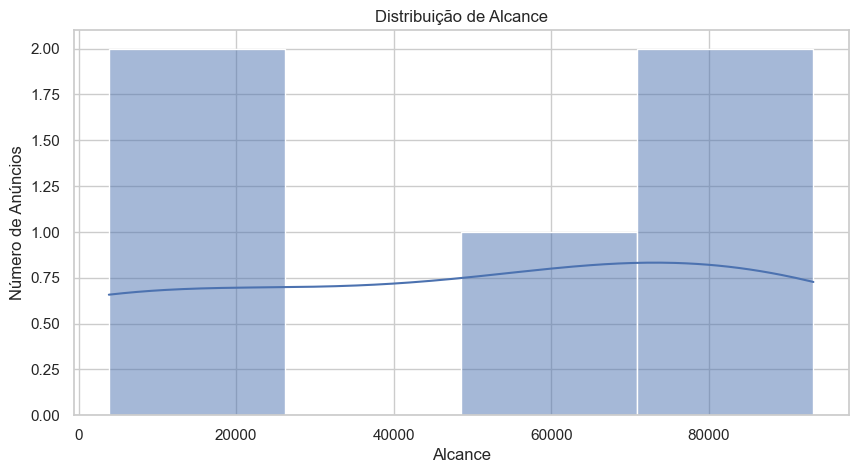

In [7]:
plt.figure(figsize=(10, 5))
sns.histplot(df["Alcance"], kde=True)
plt.title("Distribuição de Alcance")
plt.xlabel("Alcance")
plt.ylabel("Número de Anúncios")
plt.show()

## Boxplot

Este gráfico mostra um "boxplot" do custo por resultado dos anúncios, ou seja, o valor gasto, em média, para cada ação desejada. A caixa abrange a maior parte dos custos, que variam de aproximadamente 1,8 a 3,4. As extremidades da caixa representam a faixa de custo mais comum, enquanto as linhas fora dela indicam a variação total.

**Insight**: A maioria dos anúncios está com um custo por resultado dentro de um intervalo moderado, mas há uma variação significativa dentro dessa faixa. Isso sugere que, embora os custos estejam razoavelmente concentrados, pode haver espaço para otimizar e reduzir ainda mais o custo por resultado médio.

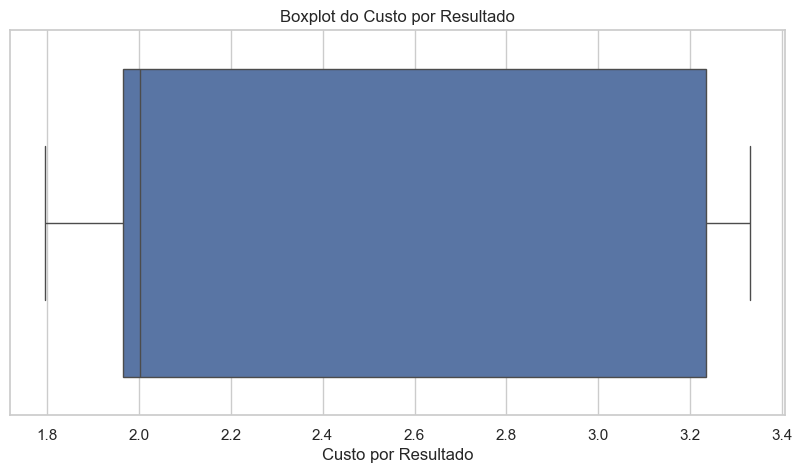

In [8]:
# Filtrar dados para remover custo por resultado igual a 0 ou NaN
df_filtrado = df[(df["Custo por resultado"] > 0) & (df["Custo por resultado"].notna())]

# Criar o boxplot
plt.figure(figsize=(10, 5))
sns.boxplot(x="Custo por resultado", data=df_filtrado)
plt.title("Boxplot do Custo por Resultado")
plt.xlabel("Custo por Resultado")
plt.show()


# Visualização das Distribuições do Custo por Resultado e Número de Anúncios"

## Histograma

Este gráfico mostra a distribuição do custo por resultado dos anúncios, indicando quantos anúncios se encontram em diferentes faixas de custo por ação gerada. A maioria dos anúncios tem um custo por resultado entre 1,8 e 2 unidades, com uma pequena quantidade alcançando a faixa de 3 a 3,2.

**Insight**: A maioria dos anúncios está com um custo por resultado relativamente baixo e controlado. No entanto, alguns anúncios com custo mais alto podem ser otimizados para garantir uma melhor eficiência e aumentar o retorno sobre o investimento.

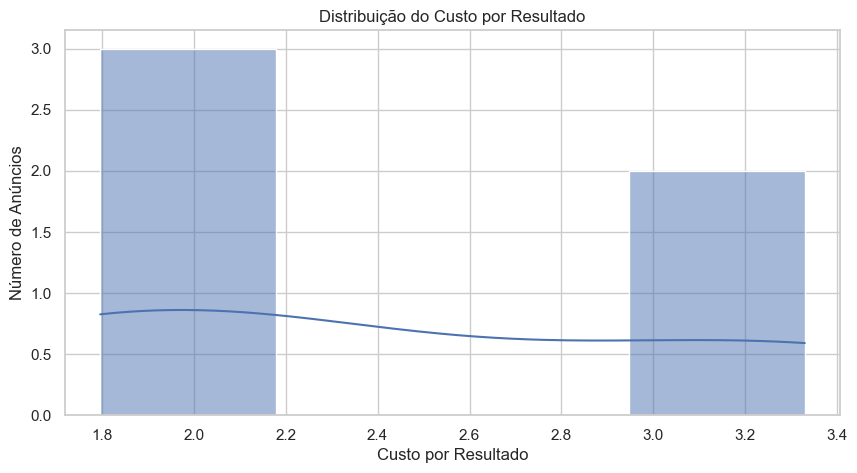

In [9]:
plt.figure(figsize=(10, 5))  # Define o tamanho do gráfico
sns.histplot(
    df["Custo por resultado"], kde=True
)  # Cria um histograma para visualizar a distribuição do "Custo por Resultado" e inclui uma linha de densidade (kde) para mostrar a tendência
plt.title("Distribuição do Custo por Resultado")  # Define o título do gráfico
plt.xlabel("Custo por Resultado")  # Nomeia o eixo X
plt.ylabel("Número de Anúncios")  # Nomeia o eixo Y
plt.show()  # Exibe o gráfico

# Análise de Relação entre CTR e Resultados

#### Gráfico de dispersão (scatter plot) 

Este gráfico mostra a relação entre o CTR (Click-Through Rate) calculado e os resultados (ações geradas) dos anúncios. Observamos que a maioria dos anúncios apresenta um CTR calculado entre 0,05 e 0,085, enquanto os resultados variam bastante, com alguns anúncios gerando mais de 80.000 ações.

**Insight**: O gráfico indica que um CTR mais alto nem sempre se traduz em um número significativamente maior de resultados. Isso sugere que fatores além do CTR, como a segmentação e a relevância do público-alvo, podem estar impactando os resultados. Vale a pena revisar esses elementos para otimizar o desempenho das campanhas.

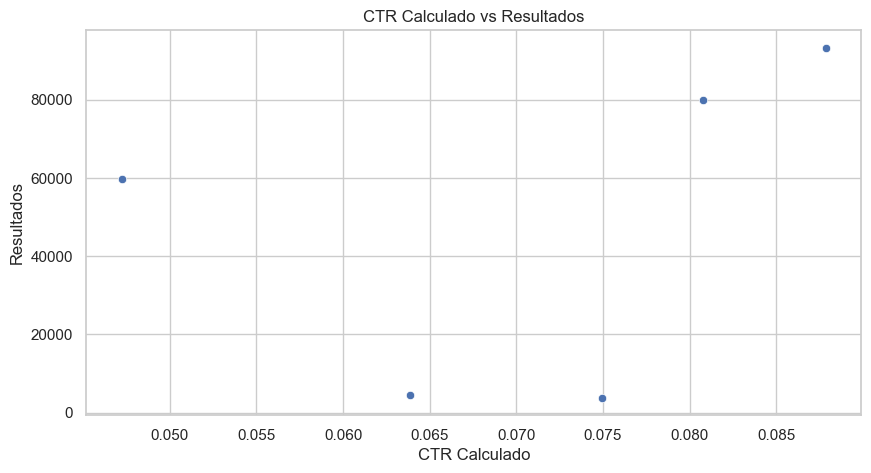

In [10]:
# Scatter plot de CTR calculado vs Resultados para avaliar relação
plt.figure(figsize=(10, 5))
sns.scatterplot(x="CTR (todos)", y="Resultados", data=df)
plt.title("CTR Calculado vs Resultados")
plt.xlabel("CTR Calculado")
plt.ylabel("Resultados")
plt.show()

#### Mapa de Calor (heatmap)

Este gráfico de densidade mostra a relação entre o CTR (Click-Through Rate) calculado e os resultados (ações geradas) dos anúncios. As áreas mais escuras indicam onde a maioria dos dados está concentrada. Observa-se que a maioria dos anúncios está agrupada em uma faixa de CTR entre 0,04 e 0,08, com resultados em torno de 50.000 a 100.000.

**Insight**: A concentração de anúncios em faixas de CTR moderadas com resultados expressivos reforça que o CTR, por si só, não é o único fator determinante para o sucesso de uma campanha. Assim como observado no gráfico anterior, onde um CTR mais alto não garantiu mais resultados, este gráfico sugere que fatores como segmentação, público-alvo e qualidade do conteúdo devem ser considerados para otimizar o desempenho dos anúncios.

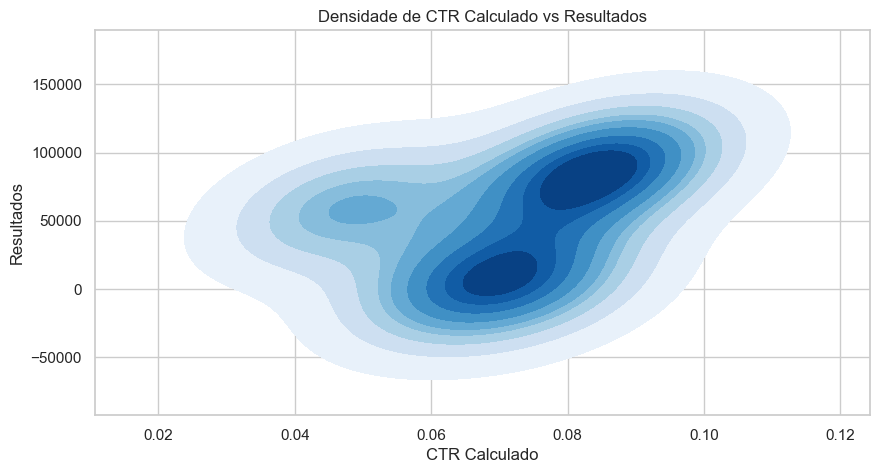

In [11]:
# Mapa de calor de densidade para CTR Calculado vs Resultados
plt.figure(figsize=(10, 5))
sns.kdeplot(x="CTR (todos)", y="Resultados", data=df, cmap="Blues", fill=True)
plt.title("Densidade de CTR Calculado vs Resultados")
plt.xlabel("CTR Calculado")
plt.ylabel("Resultados")
plt.show()

Os dois gráficos juntos reforçam a interpretação de que um CTR alto não é, por si só, um indicador forte de resultados elevados neste conjunto de dados. Outras variáveis, como segmentação, orçamento ou o tipo de campanha, podem estar influenciando mais diretamente os resultados.

Esses insights sugerem que vale a pena explorar outros fatores além do CTR para otimizar os resultados dos anúncios.

# Análise de Correlação entre Métricas

## Matriz de Correlação

**Intenção do Gráfico**: Esta matriz de correlação mostra como diferentes métricas de desempenho dos anúncios se relacionam, indicando quais variáveis aumentam ou diminuem juntas, o que pode ajudar a entender os fatores que influenciam o sucesso das campanhas.

**Interpretações Pontuais**:
- **Alcance e Impressões**: Altamente correlacionados (0,98) – quanto mais impressões, maior o alcance, o que é esperado, pois impressões mais frequentes alcançam mais pessoas.
- **Valor Usado e Resultados**: Forte relação positiva (0,98) – indica que um maior investimento geralmente está associado a um número maior de resultados.
- **CPM e Alcance**: Correlação positiva moderada (0,33) – sugere que um CPM mais alto está associado a um alcance maior, mas não é uma relação muito forte.
- **CPC (todos) e CTR (-0,58)**: Correlação negativa entre CPC (todos) e CTR, sugerindo que quanto maior o custo por clique, menor a taxa de cliques, indicando que otimizar o CPC pode aumentar a taxa de cliques.
- **Frequência e Engajamento com a Página (0,89)**: Correlação forte, indicando que campanhas com maior frequência de exibição tendem a gerar mais engajamento, mas atenção ao excesso, pois pode levar à saturação.
- **Cliques e Resultados (0,93)**: Forte correlação entre cliques e resultados, sugerindo que campanhas que atraem mais cliques também geram mais resultados, o que é um bom indicativo de engajamento.

**Insights Valiosos**:
- **Foco no Investimento Eficiente**: Investimentos mais altos geralmente geram mais resultados, mas é importante equilibrar esse valor com métricas como CPC e CTR para otimizar o retorno.
- **Atenção ao CPM**: Embora um CPM alto possa aumentar o alcance, é essencial monitorar para garantir que não limite o custo-benefício da campanha.
- **CPC e CTR**: Otimizar o CPC é essencial, pois um CPC elevado tende a reduzir a CTR, impactando a eficiência da campanha.
- **Gerenciamento de Frequência**: A alta frequência pode aumentar o engajamento com a página, mas é necessário encontrar um equilíbrio para evitar saturação do público.
- **Monitorar Cliques e Resultados**: Uma alta correlação entre cliques e resultados indica que o engajamento inicial é crucial para os resultados finais. Melhorar a taxa de cliques pode levar a um aumento proporcional nos resultados.

Esses pontos oferecem oportunidades para ajustar a estratégia de anúncios, focando em melhorar o retorno do investimento, equilibrar o alcance e a frequência, e otimizar o custo por clique para maximizar o engajamento e as conversões.

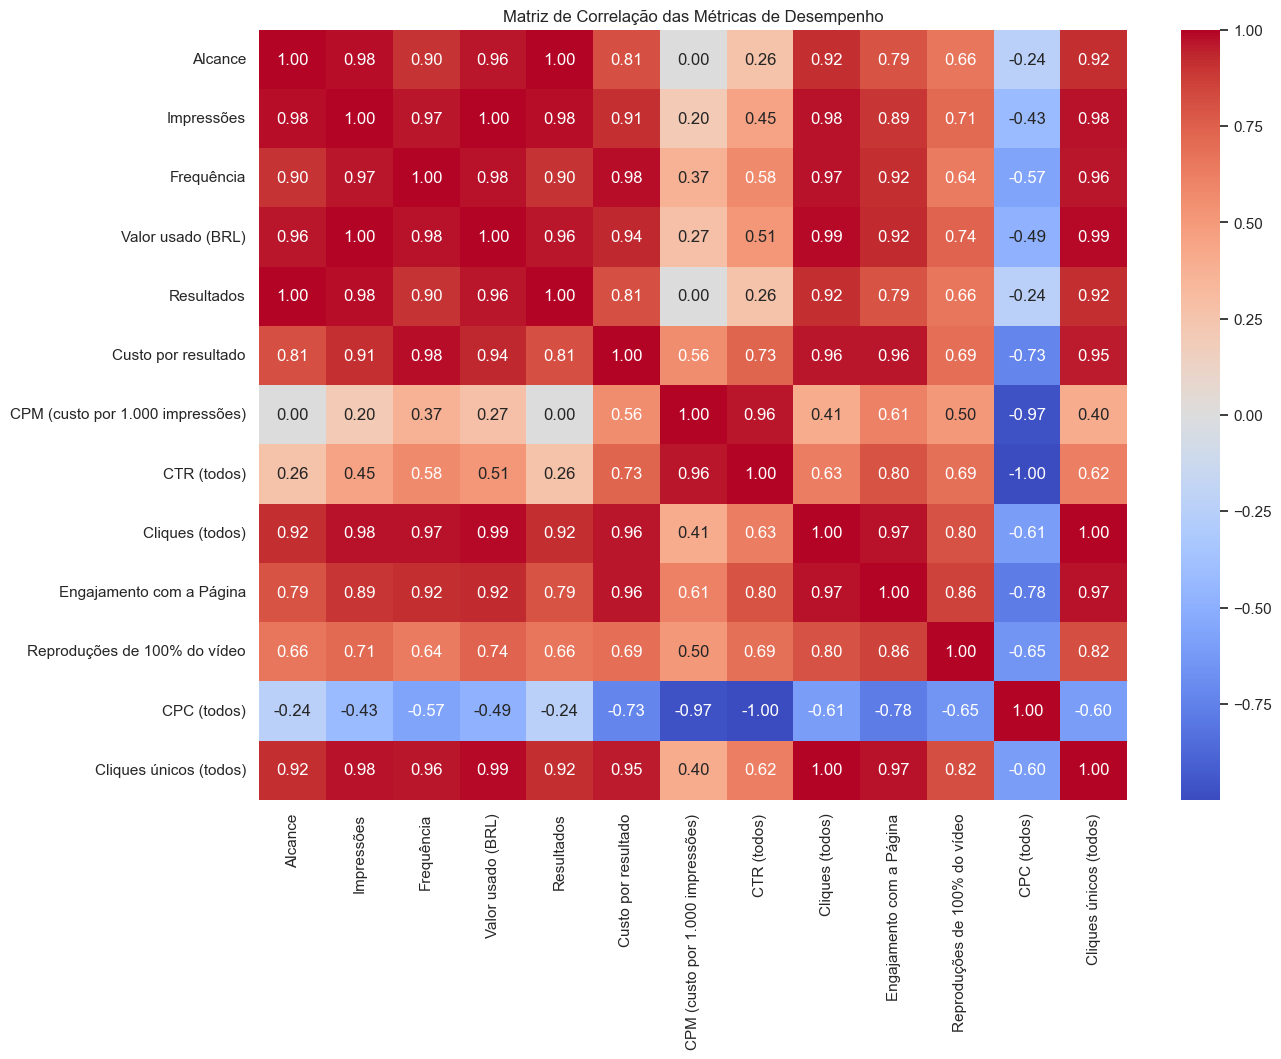

In [12]:
# Selecionando as principais métricas que queremos analisar
metricas_principais = [
    "Alcance",
    "Impressões",
    "Frequência",
    "Valor usado (BRL)",
    "Resultados",
    "Custo por resultado",
    "CPM (custo por 1.000 impressões)",
    "CTR (todos)",
    "Cliques (todos)",
    "Engajamento com a Página",
    "Reproduções de 100% do vídeo",
    "CPC (todos)",
    "Cliques únicos (todos)",
]

# Convertendo as métricas para números
# Isso ajuda a evitar erros se houver valores inválidos
for coluna in metricas_principais:
    df[coluna] = pd.to_numeric(df[coluna], errors="coerce")

# Removendo linhas que têm dados faltando nas métricas selecionadas
# Isso garante que a análise seja feita apenas com dados completos
df_corr = df[metricas_principais].dropna()

# Calculando e exibindo a matriz de correlação
# A matriz mostra como cada métrica se relaciona com as outras
correlacao = df_corr.corr()
plt.figure(figsize=(14, 10))
sns.heatmap(correlacao, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlação das Métricas de Desempenho")
plt.show()

# Identificação de Correlações Relevantes - CTR e Resultados

O resultado da análise mostra uma correlação de 0,35 entre o CTR (Click-Through Rate) e os Resultados. Esse valor indica uma correlação positiva, mas fraca, entre as duas métricas, sugerindo que, embora um CTR mais alto possa contribuir para um aumento nos resultados, ele não é o principal fator de impacto para o sucesso da campanha.

**Insight**: Esse dado reforça a ideia de que um CTR mais alto não garante necessariamente mais resultados. Para otimizar o desempenho dos anúncios, vale a pena focar em outros fatores, como segmentação de público, qualidade dos criativos e a relevância da mensagem, que podem ter um impacto mais direto nos resultados. Além disso, explorar a frequência e a estratégia de orçamento pode ajudar a melhorar os resultados de forma mais eficiente do que simplesmente tentar aumentar o CTR.

Esses insights indicam a necessidade de uma abordagem mais holística na gestão das campanhas, considerando o CTR como um componente importante, mas não definitivo para o sucesso.


In [13]:
# Remove linhas que não têm valores nas colunas 'CTR' ou 'Resultados'
df_corr = df[["CTR (todos)", "Resultados"]].dropna()

# Calcula a relação (correlação) entre o CTR e os Resultados
correlacao_ctr_resultados, _ = pearsonr(df_corr["CTR (todos)"], df_corr["Resultados"])

# Mostra a correlação calculada, limitando a duas casas decimais
print(f"Correlação entre CTR calculado e Resultados: {correlacao_ctr_resultados:.2f}")


Correlação entre CTR calculado e Resultados: 0.35


# Recomendações para Reativação ou Criação de Novos Criativos